In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
import pickle
import os


## Data Loading

In [2]:
df = pd.read_csv('../integration/integrated_traffic_spatial_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360 entries, 0 to 2359
Columns: 109 entries, NB_SCATS_SITE to roads
dtypes: float64(2), int64(103), object(4)
memory usage: 2.0+ MB


In [4]:
df.describe()

,NB_SCATS_SITE,NB_DETECTOR,V00,V01,V02,V03,V04,V05,V06,V07,...,V93,V94,V95,CT_RECORDS,QT_VOLUME_24HOUR,CT_ALARM_24HOUR,scats_id,intersection_id,x_coord,y_coord
count,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,...,2360.000000,2360.000000,2360.000000,2360.0,2360.000000,2360.000000,2360.000000,2360.000000,2360.000000,2.360000e+03
mean,3694.983051,13.516949,3.537712,3.057627,2.803814,2.453390,2.376695,1.862712,1.699153,1.442797,...,6.093644,5.425000,4.871610,96.0,1383.436864,1.485593,3694.983051,1638.898305,329881.413559,5.811844e+06
std,619.485394,7.912978,8.325374,8.167808,8.930616,7.805957,9.633340,5.474885,5.333570,4.109681,...,12.221086,11.664352,10.805304,0.0,2113.248081,11.654550,619.485394,1032.591749,1847.740420,2.503498e+03
min,2000.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,96.0,-1.000000,0.000000,2000.000000,14.000000,325759.000000,5.806464e+06
25%,3126.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,96.0,0.000000,0.000000,3126.000000,478.000000,328492.900000,5.809521e+06
50%,4030.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,96.0,3.000000,0.000000,4030.000000,1707.000000,330200.700000,5.812141e+06
75%,4264.000000,20.000000,4.000000,3.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,...,7.000000,5.250000,5.000000,96.0,2374.000000,0.000000,4264.000000,2543.000000,331251.600000,5.813492e+06
max,4324.000000,31.000000,133.000000,147.000000,220.000000,186.000000,334.000000,151.000000,132.000000,105.000000,...,110.000000,151.000000,139.000000,96.0,9414.000000,96.000000,4324.000000,3136.000000,332599.200000,5.815571e+06


In [5]:
df.shape

(2360, 109)

## Data Preprocessing

In [6]:
def preprocess_data(df):
    """Preprocess data for time series prediction models."""
    volume_cols = [f'V{str(i).zfill(2)}' for i in range(96)]

    if not all(col in df.columns for col in volume_cols):
        raise ValueError("Data does not contain all required volume columns from V00 to V95")

    data = df[['NB_SCATS_SITE', 'DATE'] + volume_cols].copy()

    data['DATE'] = pd.to_datetime(data['DATE'])

    data['DAY_OF_WEEK'] = data['DATE'].dt.dayofweek
    data['MONTH'] = data['DATE'].dt.month
    data['DAY'] = data['DATE'].dt.day

    day_dummies = pd.get_dummies(data['DAY_OF_WEEK'], prefix='DAY')
    data = pd.concat([data, day_dummies], axis=1)

    return data

processed_data = preprocess_data(df)

print("Processed data shape:", processed_data.shape)
print("Columns:", processed_data.columns.tolist())
processed_data.head()

Processed data shape: (2360, 106)
Columns: ['NB_SCATS_SITE', 'DATE', 'V00', 'V01', 'V02', 'V03', 'V04', 'V05', 'V06', 'V07', 'V08', 'V09', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'DAY_OF_WEEK', 'MONTH', 'DAY', 'DAY_1', 'DAY_2', 'DAY_3', 'DAY_4', 'DAY_5']


,NB_SCATS_SITE,DATE,V00,V01,V02,V03,V04,V05,V06,V07,...,V94,V95,DAY_OF_WEEK,MONTH,DAY,DAY_1,DAY_2,DAY_3,DAY_4,DAY_5
0,2000,2025-04-01,13,11,6,7,5,3,4,6,...,0,0,1,4,1,True,False,False,False,False
1,2000,2025-04-01,31,12,20,15,8,13,9,5,...,48,35,1,4,1,True,False,False,False,False
2,2000,2025-04-01,5,8,5,3,2,1,1,5,...,0,0,1,4,1,True,False,False,False,False
3,2000,2025-04-01,22,26,14,14,15,15,9,12,...,29,22,1,4,1,True,False,False,False,False
4,2000,2025-04-01,8,2,2,4,1,1,2,1,...,0,1,1,4,1,True,False,False,False,False


## SCATS SITE Visualization

In [7]:
available_sites = processed_data['NB_SCATS_SITE'].unique()
print(f"Number of unique SCATS sites: {len(available_sites)}")
print(f"Available site IDs (first 5): {available_sites[:5]}")

Number of unique SCATS sites: 18
Available site IDs (first 5): [2000 3002 3120 3122 3126]


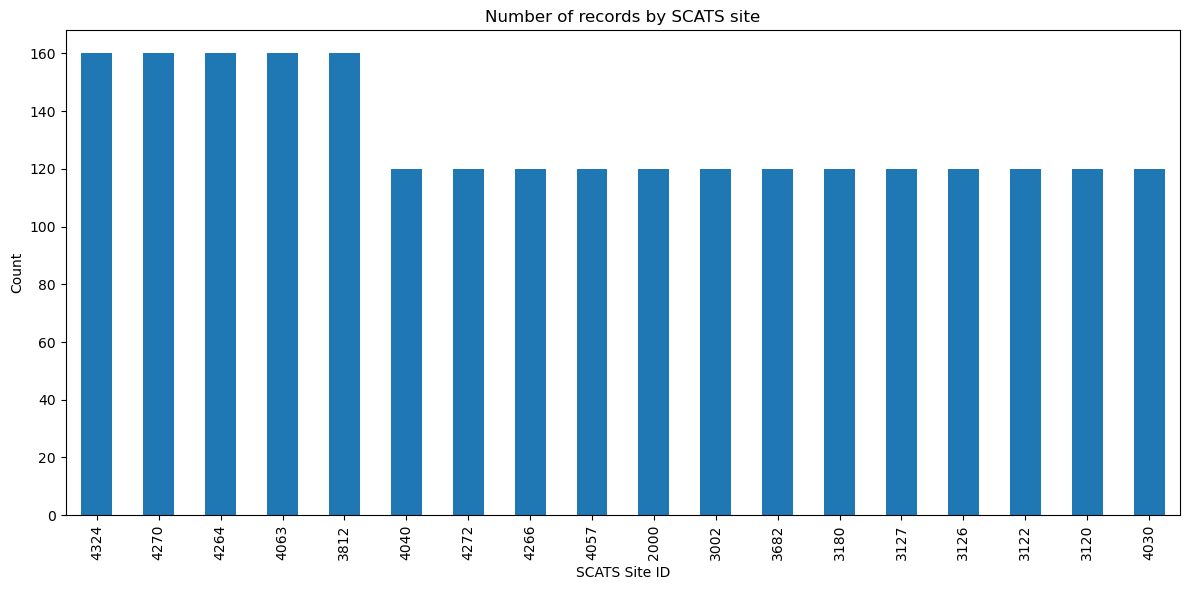

In [8]:
plt.figure(figsize=(12, 6))
processed_data['NB_SCATS_SITE'].value_counts().plot(kind='bar')
plt.title('Number of records by SCATS site')
plt.xlabel('SCATS Site ID')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Data Processing and Sequence Preparation

In [9]:
def create_sequences_all_sites(data, sequence_length=4, prediction_horizon=1):
    """
    Create time series sequences for prediction models for all SCATS sites.
    Returns a dictionary of site_id -> (X, y, scaler) for each site.
    """
    # Get unique site IDs
    site_ids = data['NB_SCATS_SITE'].unique()
    print(f"Number of unique SCATS sites: {len(site_ids)}")
    print(f"Available site IDs (first 5): {site_ids[:5]}")
    
    all_X = []
    all_y = []
    site_scalers = {}
    site_indices = []  # To keep track of which sequences belong to which site
    
    # Volume columns
    volume_cols = [f'V{str(i).zfill(2)}' for i in range(96)]
    
    # Process each site
    for site_id in site_ids:
        # Filter data for specific site
        site_data = data[data['NB_SCATS_SITE'] == site_id].sort_values('DATE')
        print(f"Processing site {site_id}: Found {len(site_data)} rows")
        
        if len(site_data) == 0:
            print(f"No data found for site_id {site_id}. Skipping.")
            continue
            
        # Check available dates
        unique_dates = site_data['DATE'].unique()
        print(f"  Found {len(unique_dates)} unique dates")
        if len(unique_dates) > 0:
            print(f"  Date range: {min(unique_dates)} to {max(unique_dates)}")
        
        # Normalize traffic volume data for this site
        scaler = MinMaxScaler()
        site_data[volume_cols] = scaler.fit_transform(site_data[volume_cols])
        site_scalers[site_id] = scaler
        
        # Select additional features (day of week)
        day_features = [col for col in site_data.columns if col.startswith('DAY_')]
        
        # Create sequences for this site
        site_X = []
        site_y = []
        
        # Process each day's data
        for _, row in site_data.iterrows():
            # Get traffic data for the entire day
            daily_data = row[volume_cols].values
            
            # Check for any NaN values
            try:
                daily_data_float = daily_data.astype(float)
                if np.isnan(daily_data_float).any():
                    print(f"  Warning: NaN values found for date {row['DATE']}, skipping")
                    continue
            except (ValueError, TypeError):
                print(f"  Warning: Non-numeric values found for date {row['DATE']}, skipping")
                continue
                
            # Create sequences for this day
            for i in range(96 - sequence_length - prediction_horizon + 1):
                # Input sequence
                input_seq = []
                for j in range(sequence_length):
                    # Traffic volume feature (single value for this time step)
                    traffic_feature = daily_data[i + j:i + j + 1]
                    
                    # Day of week info
                    day_info = row[day_features].values if day_features else np.array([])
                    
                    # Time of day (normalized)
                    time_of_day = (i + j) / 96.0
                    
                    # Site ID as a feature (normalized)
                    site_id_norm = site_id / 10000.0  # Assuming site IDs are 4-digit numbers
                    
                    # Combine features for this time step
                    features = np.concatenate([
                        traffic_feature, 
                        day_info, 
                        [time_of_day],
                        [site_id_norm]
                    ])
                    
                    input_seq.append(features)
                    
                # Output sequence (next time steps)
                output_seq = daily_data[i + sequence_length:i + sequence_length + prediction_horizon]
                
                site_X.append(input_seq)
                site_y.append(output_seq)
                
        print(f"  Created {len(site_X)} sequences for site {site_id}")
        
        # Add to our overall dataset
        all_X.extend(site_X)
        all_y.extend(site_y)
        site_indices.extend([site_id] * len(site_X))
    
    # Convert to numpy arrays
    all_X = np.array(all_X)
    all_y = np.array(all_y)
    site_indices = np.array(site_indices)
    
    print(f"Total sequences across all sites: {len(all_X)}")
    if len(all_X) > 0:
        print(f"Final combined sequence shapes - X: {all_X.shape}, y: {all_y.shape}")
    
    return all_X, all_y, site_indices, site_scalers

sequence_length = 4
prediction_horizon = 1

all_X, all_y, site_indices, site_scalers = create_sequences_all_sites(
    processed_data, sequence_length, prediction_horizon
)

X_train, X_test, y_train, y_test, sites_train, sites_test = train_test_split(
    all_X, all_y, site_indices, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

def get_site_data(site_id, X, y, sites):
    mask = sites == site_id
    return X[mask], y[mask]

Number of unique SCATS sites: 18
Available site IDs (first 5): [2000 3002 3120 3122 3126]
Processing site 2000: Found 120 rows
  Found 5 unique dates
  Date range: 2025-04-01 00:00:00 to 2025-04-05 00:00:00
  Created 11040 sequences for site 2000
Processing site 3002: Found 120 rows
  Found 5 unique dates
  Date range: 2025-04-01 00:00:00 to 2025-04-05 00:00:00
  Created 11040 sequences for site 3002
Processing site 3120: Found 120 rows
  Found 5 unique dates
  Date range: 2025-04-01 00:00:00 to 2025-04-05 00:00:00
  Created 11040 sequences for site 3120
Processing site 3122: Found 120 rows
  Found 5 unique dates
  Date range: 2025-04-01 00:00:00 to 2025-04-05 00:00:00
  Created 11040 sequences for site 3122
Processing site 3126: Found 120 rows
  Found 5 unique dates
  Date range: 2025-04-01 00:00:00 to 2025-04-05 00:00:00
  Created 11040 sequences for site 3126
Processing site 3127: Found 120 rows
  Found 5 unique dates
  Date range: 2025-04-01 00:00:00 to 2025-04-05 00:00:00
  Create

In [10]:
os.makedirs('processed_data', exist_ok=True)

np.save('processed_data/X_train.npy', X_train)
np.save('processed_data/X_test.npy', X_test)
np.save('processed_data/y_train.npy', y_train)
np.save('processed_data/y_test.npy', y_test)
np.save('processed_data/sites_train.npy', sites_train)
np.save('processed_data/sites_test.npy', sites_test)

with open('processed_data/site_scalers.pkl', 'wb') as f:
    pickle.dump(site_scalers, f)

data_info = {
    'X_train_shape': X_train.shape,
    'X_test_shape': X_test.shape,
    'y_train_shape': y_train.shape,
    'y_test_shape': y_test.shape,
    'sites_train_shape': sites_train.shape,
    'sites_test_shape': sites_test.shape,
    'n_unique_sites': len(site_scalers.keys()),
    'sequence_length': X_train.shape[1],
    'n_features': X_train.shape[2],
    'output_size': y_train.shape[1]
}

with open('processed_data/data_info.txt', 'w') as f:
    for key, value in data_info.items():
        f.write(f"{key}: {value}\n")